In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=load_path,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = Adam(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
class log_recall(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

            confmat = confusion_matrix(y_pred=pred, y_true=true)
            
            logs['recall0'] = confmat[0,0]/np.sum(confmat[0,:])
            logs['recall1'] = confmat[1,1]/np.sum(confmat[1,:])
            logs['recall2'] = confmat[2,2]/np.sum(confmat[2,:])
            logs['UAR'] = np.mean([logs['recall0'],logs['recall1'],logs['recall2']])

In [5]:
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

##### Load Model ######
load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5'
# lr = 0.00001
# lr = 0.1
num_dense1 = 792 #34,120,167,239,1239,650,788,422,598
num_dense2 = 137 #121,
epochs = 20
batch_size = 256
dropout_rate = 0.
trainable = False
addweights = True

In [6]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [7]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
    lr = args['lr']
#     lr = 0.01
#     num_dense1 = args['num_dense1']
#     num_dense2 = args['num_dense2']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str(args.values())
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_recall(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
#     print("History : %s" % history.history)
    loss = history.history['val_loss']
    print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': loss[-1], 'status': STATUS_OK}

In [8]:
space = {
    'lr' : 10 ** hp.uniform('lr',-8,-3),
#     'num_dense1' : 200 + hp.randint('num_dense1',1800),
#     'num_dense2' : 20 + hp.randint('num_dense2',480)
}


In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=20)
print('best:', best)

args {'lr': 4.836166490062578e-06}
Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/20
 - 5s - loss: 1.2954 - acc: 0.3410 - val_loss: 1.1756 - val_acc: 0.3057
Epoch 2/20
 - 4s - loss: 1.1530 - acc: 0.4014 - val_loss: 1.1745 - val_acc: 0.3202
Epoch 3/20
 - 4s - loss: 1.1081 - acc: 0.4259 - val_loss: 1.1669 - val_acc: 0.3350
Epoch 4/20
 - 4s - loss: 1.0716 - acc: 0.4496 - val_loss: 1.1694 - val_acc: 0.3333
Epoch 5/20
 - 4s - loss: 1.0457 - acc: 0.4591 - val_loss: 1.1725 - val_acc: 0.3288
Epoch 6/20
 - 4s - loss: 1.0221 - acc: 0.4697 - val_loss: 1.1773 - val_acc: 0.3287
Epoch 7/20
 - 4s - loss: 1.0014 - acc: 0.4970 - val_loss: 1.1962 - val_acc: 0.3086
Epoch 8/20
 - 4s - loss: 0.9836 - acc: 0.4950 - val_loss: 1.1872 - val_acc: 0.3193
Epoch 9/20
 - 5s - loss: 0.9717 - acc: 0.5069 - val_loss: 1.1928 - val_acc: 0.3241
Epoch 10/20
 - 4s - loss: 0.9533 - acc: 0.5180 - val_loss: 1.1921 - val_acc: 0.3239
E

Epoch 17/20
 - 5s - loss: 0.9798 - acc: 0.5154 - val_loss: 1.1934 - val_acc: 0.3408
Epoch 18/20
 - 5s - loss: 0.9780 - acc: 0.5180 - val_loss: 1.1920 - val_acc: 0.3449
Epoch 19/20
 - 5s - loss: 0.9761 - acc: 0.5157 - val_loss: 1.2020 - val_acc: 0.3345
Epoch 20/20
 - 5s - loss: 0.9657 - acc: 0.5262 - val_loss: 1.2031 - val_acc: 0.3348
[1.1745286410121243, 1.178851966961853, 1.1729166026985938, 1.1769384762896504, 1.185311657531385, 1.1822760975653208, 1.1960441578961198, 1.1906381689560186, 1.1880987138774155, 1.190768401044591, 1.1923522033223664, 1.1879119671657885, 1.192897498770046, 1.1968321033654485, 1.1951931062121481, 1.1964511458815281, 1.1933552728361914, 1.1920378724625715, 1.201976781969824, 1.2031058261439975]
args {'lr': 2.8465540585127514e-05}
Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/20
 - 5s - loss: 1.1554 - acc: 0.4234 - val_loss: 1.2041 - val_acc: 0.3365
Epoch 2/20
 - 5s

 - 5s - loss: 0.9117 - acc: 0.5446 - val_loss: 1.1900 - val_acc: 0.3363
Epoch 9/20
 - 4s - loss: 0.8893 - acc: 0.5565 - val_loss: 1.2001 - val_acc: 0.3454
Epoch 10/20
 - 5s - loss: 0.8776 - acc: 0.5657 - val_loss: 1.2158 - val_acc: 0.3309
Epoch 11/20
 - 5s - loss: 0.8580 - acc: 0.5745 - val_loss: 1.2164 - val_acc: 0.3369
Epoch 12/20
 - 4s - loss: 0.8343 - acc: 0.5885 - val_loss: 1.2161 - val_acc: 0.3459
Epoch 13/20
 - 4s - loss: 0.8283 - acc: 0.5978 - val_loss: 1.2181 - val_acc: 0.3403
Epoch 14/20
 - 4s - loss: 0.8129 - acc: 0.6041 - val_loss: 1.2236 - val_acc: 0.3518
Epoch 15/20
 - 4s - loss: 0.7978 - acc: 0.6128 - val_loss: 1.2199 - val_acc: 0.3600
Epoch 16/20
 - 5s - loss: 0.7852 - acc: 0.6245 - val_loss: 1.2506 - val_acc: 0.3416
Epoch 17/20
 - 5s - loss: 0.7691 - acc: 0.6369 - val_loss: 1.2482 - val_acc: 0.3505
Epoch 18/20
 - 5s - loss: 0.7548 - acc: 0.6396 - val_loss: 1.2520 - val_acc: 0.3539
Epoch 19/20
 - 5s - loss: 0.7422 - acc: 0.6439 - val_loss: 1.2440 - val_acc: 0.3641
Epoch

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/20
 - 5s - loss: 1.1253 - acc: 0.4415 - val_loss: 1.1765 - val_acc: 0.3271
Epoch 2/20
 - 5s - loss: 0.9372 - acc: 0.5302 - val_loss: 1.1858 - val_acc: 0.3369
Epoch 3/20
 - 5s - loss: 0.8584 - acc: 0.5775 - val_loss: 1.2204 - val_acc: 0.3387
Epoch 4/20
 - 5s - loss: 0.7952 - acc: 0.6194 - val_loss: 1.2284 - val_acc: 0.3358
Epoch 5/20
 - 5s - loss: 0.7471 - acc: 0.6494 - val_loss: 1.2511 - val_acc: 0.3467
Epoch 6/20
 - 4s - loss: 0.6815 - acc: 0.6874 - val_loss: 1.2823 - val_acc: 0.3508
Epoch 7/20
 - 5s - loss: 0.6377 - acc: 0.7089 - val_loss: 1.2750 - val_acc: 0.3590
Epoch 8/20
 - 5s - loss: 0.6008 - acc: 0.7293 - val_loss: 1.3352 - val_acc: 0.3466
Epoch 9/20
 - 5s - loss: 0.5565 - acc: 0.7545 - val_loss: 1.3363 - val_acc: 0.3665
Epoch 10/20
 - 5s - loss: 0.5263 - acc: 0.7679 - val_loss: 1.3335 - val_acc: 0.3661
Epoch 11/20
 - 5s - loss: 0.4920 - a

Epoch 18/20
 - 5s - loss: 1.1307 - acc: 0.4197 - val_loss: 1.1956 - val_acc: 0.3190
Epoch 19/20
 - 5s - loss: 1.1238 - acc: 0.4214 - val_loss: 1.1937 - val_acc: 0.3224
Epoch 20/20
 - 5s - loss: 1.1219 - acc: 0.4242 - val_loss: 1.1905 - val_acc: 0.3290
[1.2247131609786759, 1.2537870868350245, 1.2617318607481038, 1.256811260527421, 1.2454949958447865, 1.2357368183395843, 1.2265093570184318, 1.2204886947730582, 1.2177958290323574, 1.2120870111423876, 1.2081413476928378, 1.2037356276603095, 1.2009798450755813, 1.2018698057621637, 1.196656298897247, 1.194870641510883, 1.1933097202706402, 1.195630143708689, 1.1937392381621317, 1.1904934313381725]
args {'lr': 6.480347265480266e-05}
Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/20
 - 5s - loss: 1.0751 - acc: 0.4579 - val_loss: 1.2026 - val_acc: 0.2830
Epoch 2/20
 - 5s - loss: 0.9000 - acc: 0.5564 - val_loss: 1.2417 - val_acc: 0.3370
Epoch 3/20
 - 5s 

 - 4s - loss: 0.9744 - acc: 0.5188 - val_loss: 1.2021 - val_acc: 0.3353
Epoch 10/20
 - 5s - loss: 0.9594 - acc: 0.5278 - val_loss: 1.2148 - val_acc: 0.3323
Epoch 11/20
 - 5s - loss: 0.9378 - acc: 0.5447 - val_loss: 1.2110 - val_acc: 0.3365
Epoch 12/20
 - 5s - loss: 0.9295 - acc: 0.5493 - val_loss: 1.2208 - val_acc: 0.3403
Epoch 13/20
 - 5s - loss: 0.9176 - acc: 0.5575 - val_loss: 1.2344 - val_acc: 0.3294
Epoch 14/20
 - 5s - loss: 0.9058 - acc: 0.5600 - val_loss: 1.2426 - val_acc: 0.3232
Epoch 15/20
 - 5s - loss: 0.8907 - acc: 0.5677 - val_loss: 1.2307 - val_acc: 0.3345
Epoch 16/20
 - 5s - loss: 0.8860 - acc: 0.5746 - val_loss: 1.2251 - val_acc: 0.3433
Epoch 17/20
 - 5s - loss: 0.8738 - acc: 0.5795 - val_loss: 1.2253 - val_acc: 0.3413
Epoch 18/20
 - 5s - loss: 0.8614 - acc: 0.5880 - val_loss: 1.2493 - val_acc: 0.3287
Epoch 19/20
 - 5s - loss: 0.8476 - acc: 0.5959 - val_loss: 1.2453 - val_acc: 0.3403
Epoch 20/20
 - 5s - loss: 0.8425 - acc: 0.5947 - val_loss: 1.2440 - val_acc: 0.3426
[1.1

In [10]:
it=0
loss = np.zeros(len(trials))
params = np.zeros((len(trials),3))
for objects in trials.trials:
                  loss[it] = objects['result']['loss'] 
                  params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
#                   params[it,1] = objects['misc']['vals']['num_dense1'][0]
#                   params[it,2] = objects['misc']['vals']['num_dense2'][0]
                  it+=1

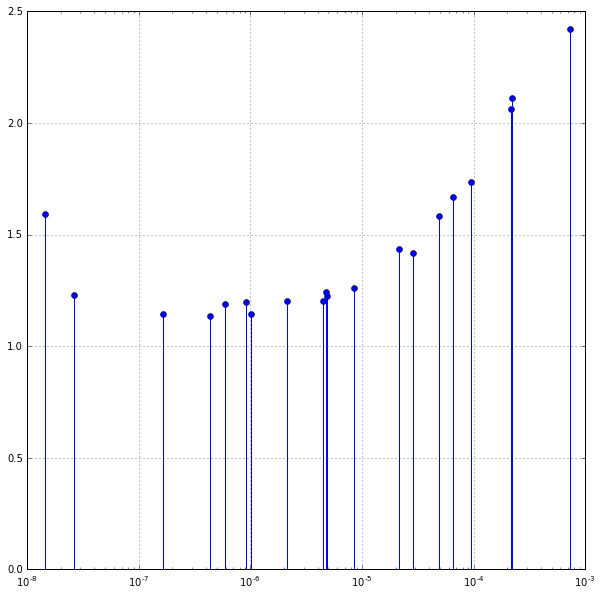

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.stem(params[:,0],loss[:])
# plt.scatter(params[:,0][mask]+200,params[:,2][mask]+20,c=loss[:][mask],s=loss[:][mask]*200)
# plt.yscale('log')
# plt.ylim([1,2])
plt.xscale('log',nonposy='clip')
plt.xlim([10**-8,10**-3])
# plt.colorbar()
plt.grid()
plt.show()

In [13]:
mask = loss>0

In [14]:
params[mask]

array([[2.22893388e-06, 0.00000000e+00, 0.00000000e+00],
       [7.81573129e-07, 0.00000000e+00, 0.00000000e+00],
       [1.43763440e-04, 0.00000000e+00, 0.00000000e+00],
       [1.49010105e-05, 0.00000000e+00, 0.00000000e+00],
       [1.37217731e-04, 0.00000000e+00, 0.00000000e+00]])